# Data Preprocessing

## Load Data and Clean Up

In [17]:
# Prepare input data
import ast
import pandas as pd
import numpy as np
from math import isnan
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import box
from sklearn.model_selection import train_test_split
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
import contextily


# set print options
np.set_printoptions(linewidth=110)
pd.set_option('display.width', 200)
plt.style.use('bmh')  # better for plotting geometries vs general plots.

# Import only first 1000 lines for testing
df = pd.read_csv('./data/sensor_readings_timeseries.csv', parse_dates=["Timestamp"])
df = df.drop(
    ["Metadata.Location.type", "Metadata.SensorCommunitySensorType", "Metadata.SensorType", "_id"], axis=1)

# Convert string coordinates to list
df["Metadata.Location.coordinates"] = df["Metadata.Location.coordinates"].apply(
    lambda x: ast.literal_eval(x))

# no preprocessing needed
sensor_community_df = df.loc[df["Metadata.Provider"] == "sensor.community"].drop(
    ["Metadata.Provider", "Metadata.NetatmoSensorId"], axis=1)

# need to combine multiple entries for the same sensor id and time
netatmo_df = df.loc[df["Metadata.Provider"] == "netatmo"].drop(
    ["Metadata.Provider"], axis=1)

# get unique groups
grouped = netatmo_df.groupby(
    ["Metadata.NetatmoSensorId", "Timestamp"]).aggregate(list)

combined_rows = []
for label, group in grouped.iterrows():
    humidity = next((x for x in group.values[0] if not isnan(x)), np.NaN)
    pressure = next((x for x in group.values[2] if not isnan(x)), np.NaN)
    temperature = next((x for x in group.values[3] if not isnan(x)), np.NaN)

    # Humidity, Metadata.Location.coordinates, Pressure, Temperature, Timestamp
    entry = [humidity, group.values[1][0], pressure, temperature, label[1]]
    combined_rows.append(entry)

netatmo_df = pd.DataFrame(combined_rows, columns=[
                          "Humidity", "Metadata.Location.coordinates", "Pressure", "Temperature", "Timestamp"])

# Combine prepared data
prep = pd.concat([sensor_community_df, netatmo_df], ignore_index=True, axis=0)
prep = prep[prep["Temperature"].notna()]

coordinates = prep["Metadata.Location.coordinates"]

# TODO: try out WGS84
proj_wgs = 4326

geo_df = GeoDataFrame(prep[["Humidity", "Pressure", "Temperature", "Timestamp"]],
                          geometry=prep["Metadata.Location.coordinates"].apply(lambda row: Point(row[0], row[1])), crs=proj_wgs)

geo_df.to_csv("./data/geo_df.csv")

# Outlier detection
# TODO: remove outliers if temp too high (humidty)
# DWD as reference

# Evaluation -> show original vs cleaned data, quality steps


/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_43466/1560243432.py:25: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/sensor_readings_timeseries.csv', parse_dates=["Timestamp"])


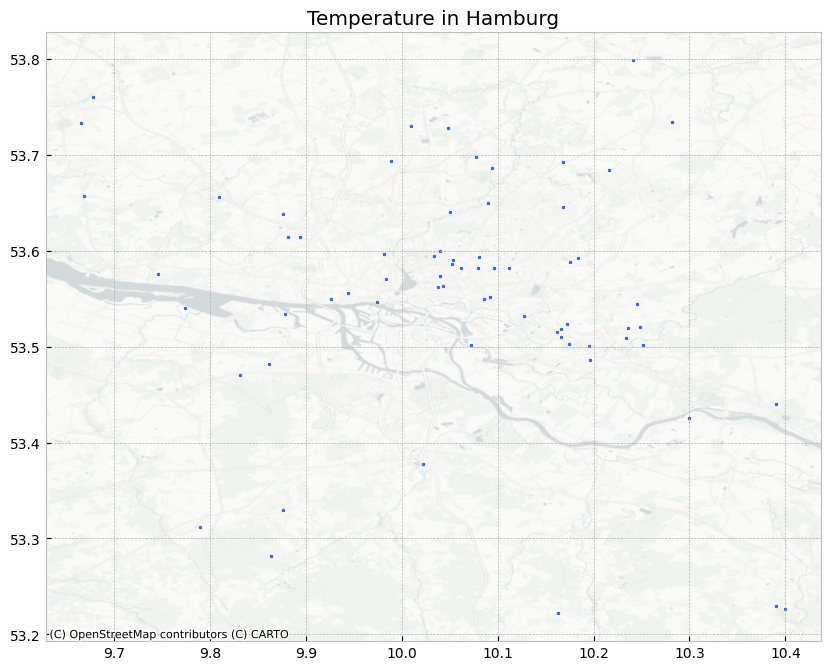

In [4]:
# Plot data
from geopandas.tools import sjoin

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.style.use('bmh')

geo_df.plot(ax=ax, marker='o', color='royalblue', markersize=3)

ax.set_title('Temperature in Hamburg')

# Add basemap
contextily.add_basemap(
    ax,
    crs=proj_wgs,
    source=contextily.providers.CartoDB.PositronNoLabels,
)


## Data Set Creation

In 10 min time intervals, for each location create 'number of neighbours * number of features' tensor together with the observed temperature as Y.

The features in the first iteration should be:
Temperature, Distance to the neighbour using Euclidiean Distance
Both features need to be normalized

In [17]:
# Create test dataset
from pytz import UTC
from scipy.spatial import KDTree
from shapely.geometry import Point
import pandas as pd
import numpy as np
import csv
import geopandas as gpd
from geopandas import GeoDataFrame
from math import isnan

proj_wgs = 4326

df = pd.read_csv("./data/geo_df.csv", parse_dates=["Timestamp"], index_col=0, nrows=500000)
geo_df = GeoDataFrame(
    df.loc[:, [c for c in df.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(df["geometry"]),
    crs=proj_wgs)

start = geo_df["Timestamp"].values[0]
# start = np.datetime64('2023-01-26T03:37:00.000000000')
end = geo_df["Timestamp"].values[-1]

print(f"Start time: {start}")
print(f"End time: {end}")

# The more neighbors the more accurate the prediction but the longer the query time (smooths out the data)
nearest_neighbors_count = 10

X = []
y = []

for date in pd.date_range(start=start, end=end, freq='5min'):
    start_time = date.tz_localize(UTC)
    end_time = start_time + pd.Timedelta(minutes=5)

    print(start_time)
    print(end_time)
    
    filtered_gdf = geo_df[(geo_df['Timestamp'] >= start_time) & (geo_df['Timestamp'] < end_time)]

    if filtered_gdf.size < 11:
        # Skip if no entries for that time frame
        continue

    # Do outlier detection with the median temperature of the overall dataset for that time period
    mean_temp = filtered_gdf['Temperature'].mean()

    if isnan(mean_temp):
        print('mean is nan')
        continue

    # Do +- 2.5 degrees
    min_temp = mean_temp - 2.5
    max_temp = mean_temp + 2.5

    filtered_gdf = filtered_gdf[(filtered_gdf['Temperature'] >= min_temp) & (filtered_gdf['Temperature'] < max_temp)]

    print(f"Mean temperature: {mean_temp}")

    # Build neighbor tree
    locations = list(filtered_gdf.geometry.apply(lambda x: (x.x, x.y)))

    if len(locations) < 11:
        # Skip if there are less neighbors than the nearest neighbors count
        print(f'not enough neighbors for start time {start_time} and end time {end_time}')
        continue

    # More build time but better query time
    tree = KDTree(locations, balanced_tree=True)

    for entry in filtered_gdf.values:
        # Find k nearest neighbors
        location = entry[-1]
        neighbours_gdf = filtered_gdf[filtered_gdf.geometry.apply(lambda x: not x.equals(location))]

        # Get nearest neighbors including current location, euclidean distance
        dist, idx = tree.query(entry[-1].coords, k=nearest_neighbors_count + 1, p=2)

        idx = idx[0]
        dist = dist[0]

        # Skip first entry as it is the current location, rest of the locations should be unique
        idx = idx[1:]
        dist = dist[1:]

        # Drop Timestamp and geometry
        gdB_nearest = filtered_gdf.iloc[idx].drop(
            ['Timestamp', 'geometry', 'Humidity', 'Pressure'], axis=1).reset_index(drop=True)
        gdf = pd.concat(
            [
                gdB_nearest,
                pd.Series(dist, name='Distance')
            ],
            axis=1)

        X.append([item for rows in gdf.values for item in rows])
        y.append(entry[2])

print(X[0])
print(y[0])

# Save X, y as csv
with open('dataset.csv', 'w', newline='') as csvfile:
    combined_Xy = np.concatenate((X, np.array(y).reshape(-1, 1)), axis=1)
    writer = csv.writer(csvfile)
    writer.writerows(combined_Xy)

def to_numpy_list(geo_series):
    return [[point.x, point.y]
            for point in geo_series.to_numpy()]

def geo_df_to_train_test_sets(gdf: gpd.GeoDataFrame, target_feature: str = 'Temperature') :
    """
    Splits a GeoDataFrame into train and test sets.
    :param gdf: The GeoDataFrame to split.
    :param target_feature: The name of the target feature. Can be any column in the GeoDataFrame: 'Temperature', 'Humidity', 'Pressure'.
    """
    coords_train, coords_test, value_train, value_test = train_test_split(
        gdf.geometry, gdf[target_feature], test_size=0.2, random_state=1)
    
    coords_train = to_numpy_list(coords_train)
    coords_test = to_numpy_list(coords_test)

    return coords_train, coords_test, value_train, value_test


Start time: 2023-01-22T09:42:04.000000000
End time: 2023-02-01T04:40:16.000000000
2023-01-22 09:42:04+00:00
2023-01-22 09:47:04+00:00
Mean temperature: 4.164444444444445
2023-01-22 09:47:04+00:00
2023-01-22 09:52:04+00:00
Mean temperature: 4.262333333333333
2023-01-22 09:52:04+00:00
2023-01-22 09:57:04+00:00
Mean temperature: 4.404137931034483
2023-01-22 09:57:04+00:00
2023-01-22 10:02:04+00:00
Mean temperature: 4.384603174603174
2023-01-22 10:02:04+00:00
2023-01-22 10:07:04+00:00
Mean temperature: 4.518666666666666
2023-01-22 10:07:04+00:00
2023-01-22 10:12:04+00:00
Mean temperature: 4.466551724137931
2023-01-22 10:12:04+00:00
2023-01-22 10:17:04+00:00
Mean temperature: 4.506379310344828
2023-01-22 10:17:04+00:00
2023-01-22 10:22:04+00:00
2023-01-22 10:22:04+00:00
2023-01-22 10:27:04+00:00
2023-01-22 10:27:04+00:00
2023-01-22 10:32:04+00:00
2023-01-22 10:32:04+00:00
2023-01-22 10:37:04+00:00
2023-01-22 10:37:04+00:00
2023-01-22 10:42:04+00:00
2023-01-22 10:42:04+00:00
2023-01-22 10:47

### KNN with Sklearn

In [58]:
from sklearn import neighbors

n_neighbors = 5

knn_regressor = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')

coords_geo_train, coords_geo_test, value_geo_train, value_geo_test = geo_df_to_train_test_sets(
    filtered_gdf)

# Fit regressor to data
knn_regressor.fit(coords_geo_train, value_geo_train)

# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(coords_geo_test, value_geo_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

# Predict values for testing dataset
coords_rain_test_predict_knn = knn_regressor.predict(coords_geo_test)

# Create dictionary holding the actual and predicted values
predict_dict_knn = {"Coordinate_Pair": coords_geo_test,
                    "VALUE_Actual": value_geo_test, "VALUE_Predict": coords_rain_test_predict_knn}

# Create dataframe from dictionary
predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - KNN Method")
display(predict_df_knn.head(10))


KNN out-of-sample r-squared: -1.92

Attribute Table: Testing Set Interpolated Values - KNN Method


,Coordinate_Pair,VALUE_Actual,VALUE_Predict
186,"[10.08, 53.582]",7.98,7.084931
261,"[10.184, 53.592]",4.55,5.466880
315,"[9.9886339555, 53.6937804]",5.40,4.748864
197,"[10.022, 53.378]",5.35,6.682210
74,"[10.04, 53.574]",5.24,7.011791
16,"[9.894, 53.614]",4.70,6.043133
244,"[10.096, 53.582]",5.11,7.084937
344,"[9.746, 53.576]",4.22,6.162308
297,"[9.774, 53.54]",4.96,5.782469
162,"[9.862, 53.482]",3.92,6.862244


# Kriging Reference Interpolation

In [59]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(
        min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode="w",
            driver="GTiff",
            height=Z.shape[0],
            width=Z.shape[1],
            count=1,
            dtype=Z.dtype,
            crs=proj,
            transform=transform,
    ) as new_dataset:
        new_dataset.write(Z, 1)

In [121]:
# Reference Krigin interpolation
# see: https://pygis.io/docs/e_interpolation.html#kriging
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score
from sklearn import preprocessing

# Define functions
def interpolate_ordinary_kriging(base_gdf: GeoDataFrame, variogram_model: str, target_feature: str = 'Temperature', normalize: bool = False):
    """
    Interpolate data using ordinary kriging.

    :param base_gdf: GeoDataFrame containing the data to be interpolated
    :param variogram_model: The variogram model to be used for interpolation. Possible values: linear, power, gaussian, spherical, exponential, hole-effect
    :param target_feature: The name of the target feature. Can be any column in the GeoDataFrame: 'Temperature', 'Humidity', 'Pressure'.
    """
    # Drop rows with missing values
    base_gdf = GeoDataFrame(base_gdf.dropna(subset=[target_feature]))

    # Normalize data
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        base_gdf[target_feature] = min_max_scaler.fit_transform(
            base_gdf[target_feature].values.reshape(-1, 1))

    x_coords = base_gdf.geometry.x
    y_coords = base_gdf.geometry.y

    coords_train, coords_test, value_train, value_test = geo_df_to_train_test_sets(
        base_gdf, target_feature)
    
    # Get outer bounds for data points
    minx, miny, maxx, maxy = geo_df.total_bounds

    # Add buffer to outer bounds
    minx -= .2
    miny -= .1
    maxx += .2
    maxy += .1

    # Create a 100 by 100 grid from the outer bounds
    grid_lon = np.linspace(minx, maxx, 100)
    grid_lat = np.linspace(miny, maxy, 100)

    # Generate ordinary krigin object
    OK = OrdinaryKriging(
        [item[0] for item in coords_train],
        [item[1] for item in coords_train],
        value_train,
        variogram_model=variogram_model,
        verbose=False,
        enable_plotting=False,
        coordinates_type="euclidean",
    )

    # Evaluate the method on grid
    Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", grid_lon, grid_lat)

    filename = f'./data/hamburg_{target_feature}_krigin_{variogram_model}.tif'

    # Export raster
    export_kde_raster(Z=Z_pk_krig, XX=grid_lon, YY=grid_lat, min_x=minx, max_x=maxx, min_y=miny,
                  max_y=maxy, proj=proj_wgs, filename=filename)

    # Open raster
    raster_pk = rasterio.open(filename)

    # Create polygon with extend of raster
    poly_shapely = box(*raster_pk.bounds)

    # Create a dictionary with needed attributes and required geometry column
    attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

    # Convert shapely object to a GeoDataFrame
    raster_pk_extent = GeoDataFrame(
        attributes_df, geometry='geometry', crs=proj_wgs)
    
    # Create copy of test dataset
    temp_test_gdf_pk_krig = base_gdf.copy()

    # Subset the GeoDataFrame by checking which test points are within the raster extent polygon
    # If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
    temp_test_gdf_pk_krig = temp_test_gdf_pk_krig[temp_test_gdf_pk_krig.within(
        raster_pk_extent.geometry.values[0])]

    # Create list of XY coordinate pairs for the test points that fall within raster extent polygon
    coords_rain_test_pk_krig = [list(xy) for xy in zip(
        temp_test_gdf_pk_krig["geometry"].x, temp_test_gdf_pk_krig["geometry"].y)]

    # Extract raster value at each test point and add the values to the GeoDataFrame
    temp_test_gdf_pk_krig["VALUE_Predict"] = [x[0]
                                            for x in raster_pk.sample(coords_rain_test_pk_krig)]

    # Generate out-of-sample R^2
    out_r_squared_tp = r2_score(
        temp_test_gdf_pk_krig.Temperature, temp_test_gdf_pk_krig.VALUE_Predict)
    print(
        f'PyKrige Kriging out-of-sample r-squared for variogram model {variogram_model} and target feature {target_feature}: {round(out_r_squared_tp, 2)}')
    
    return raster_pk_extent, raster_pk, x_coords, y_coords, coords_train, coords_test, value_train, value_test, Z_pk_krig, sigma_squared_p_krig, poly_shapely


def plot_kriging_data(input_raster, x_coords, y_coords, norm, variogram_model: str, target_feature: str = 'Temperature', label: str = 'Temperature (°C)'):
    # Mask raster to hamburg shape
    # out_image_pk, out_transform_pk = rasterio.mask.mask(
    #     input_raster, ge5000_clipped.geometry.values, crop=True)
    # TODO: mask out water bodies?
    
    # Reset plot
    plt.clf()
    
    # Plot data
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    plot = show(input_raster, ax=ax, cmap="RdPu", norm=norm)
    ax.plot(x_coords, y_coords, 'k.', markersize=2, alpha=0.5)

    # ge5000_clipped.plot(ax=ax, color='none', edgecolor='dimgray')
    plt.gca().invert_yaxis()

    fig.subplots_adjust(right=0.8)

    cbar_ax = fig.add_axes([0.85, 0.275, 0.05, 0.45])

    # TODO: adding basemap without changing the color map through alpha channel
    # Add basemap - needs to be first
    # contextily.add_basemap(
    #     ax,
    #     crs=proj_wgs,
    #     source=contextily.providers.CartoDB.PositronNoLabels,
    #     alpha=0.1
    # )

    # Set title

    # Display plot
    fig.colorbar(plot.get_images()[0], cax=cbar_ax, label=label)

    ax.set_title(f'Hamburg - Interpolating {target_feature} using Kriging with {variogram_model} variogram model',
                 fontdict={'fontsize': '15', 'fontweight': '3'})

    plt.show()

# Set projection to WGS 84 and reproject data
krigin_gdf = filtered_gdf.to_crs(epsg=proj_wgs)


## Temperature Interpolation using Ordinary Kriging

PyKrige Kriging out-of-sample r-squared for variogram model linear and target feature Temperature: 0.33
PyKrige Kriging out-of-sample r-squared for variogram model power and target feature Temperature: 0.11
PyKrige Kriging out-of-sample r-squared for variogram model gaussian and target feature Temperature: 0.06
PyKrige Kriging out-of-sample r-squared for variogram model spherical and target feature Temperature: 0.44
PyKrige Kriging out-of-sample r-squared for variogram model exponential and target feature Temperature: 0.68
PyKrige Kriging out-of-sample r-squared for variogram model hole-effect and target feature Temperature: 0.68


<Figure size 640x480 with 0 Axes>

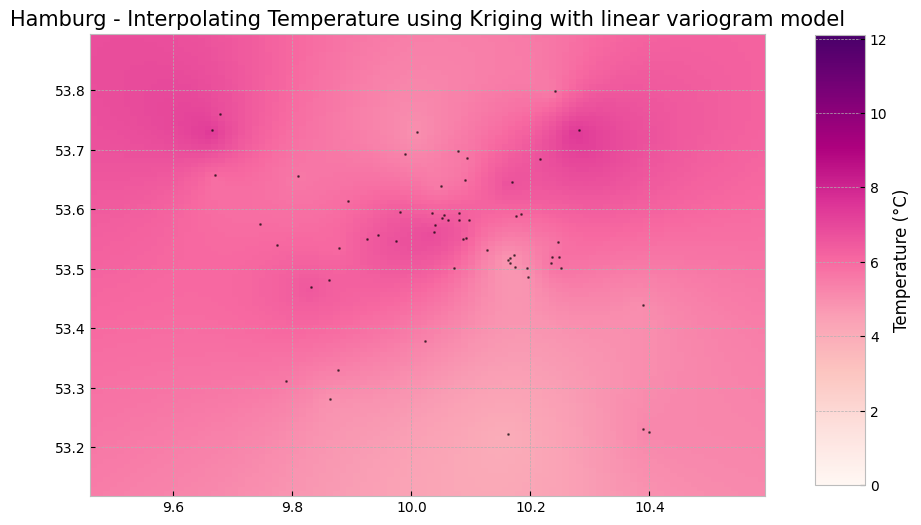

<Figure size 640x480 with 0 Axes>

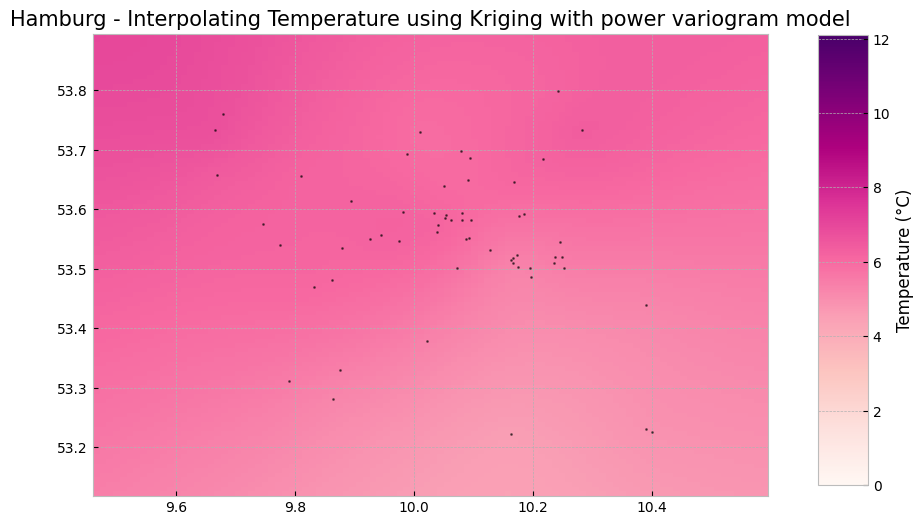

<Figure size 640x480 with 0 Axes>

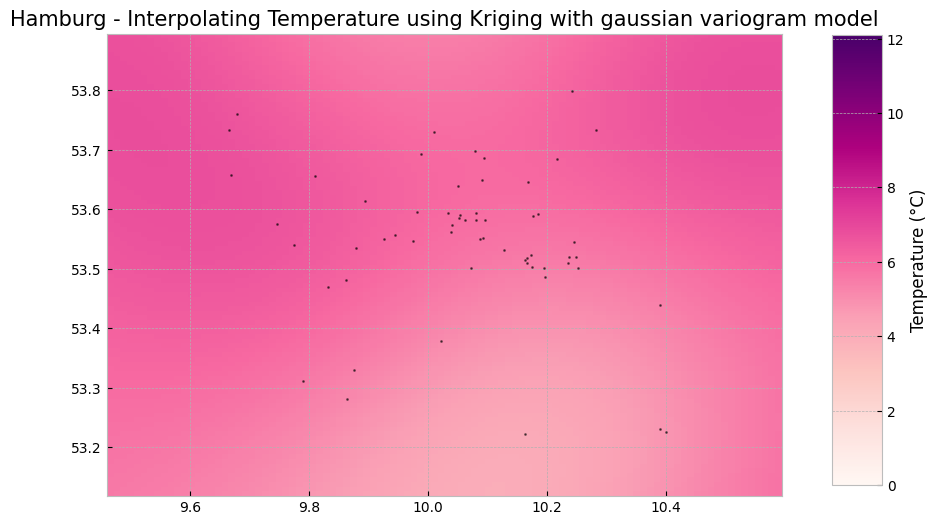

<Figure size 640x480 with 0 Axes>

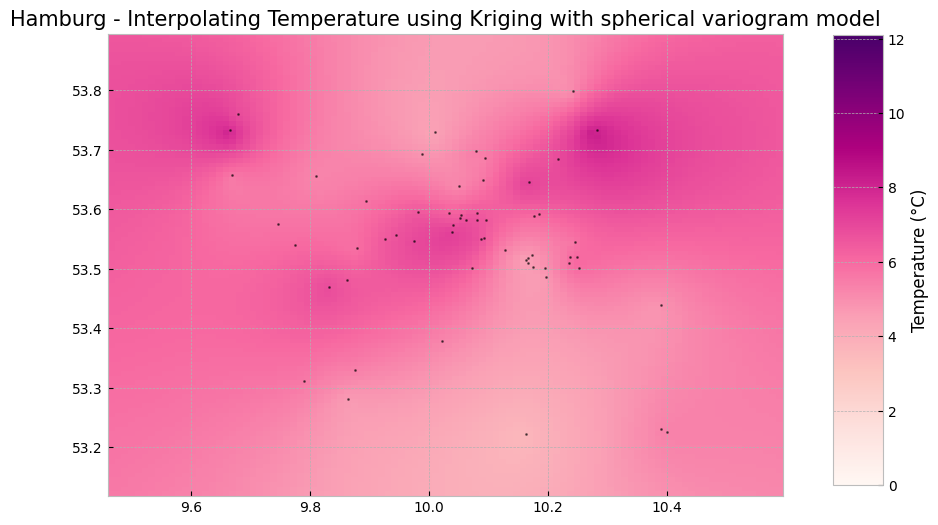

<Figure size 640x480 with 0 Axes>

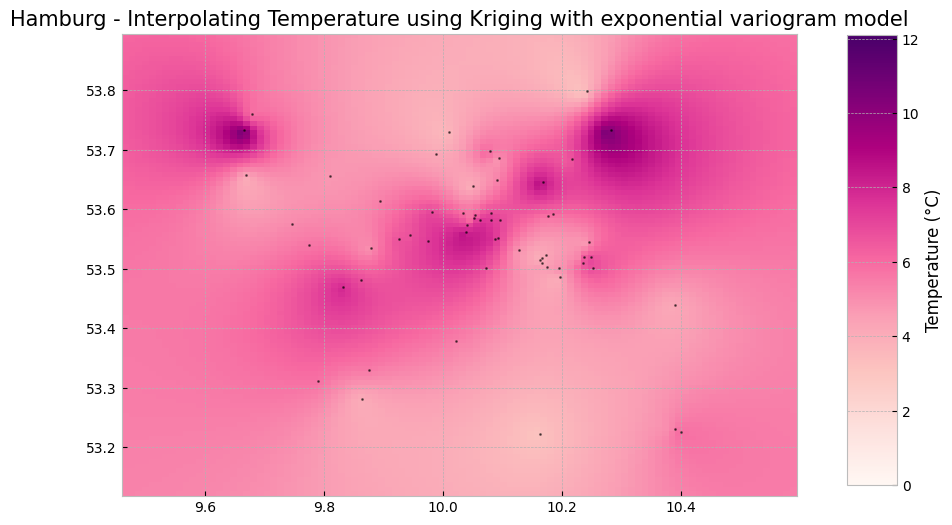

<Figure size 640x480 with 0 Axes>

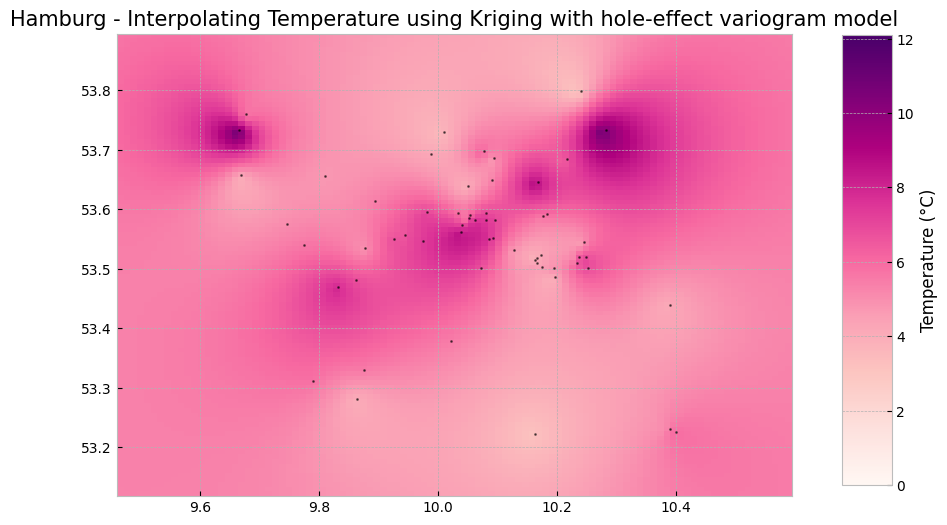

In [122]:
# Interpolate temperature data using ordinary kriging with various variogram models to compare r2 scores
raster_pk_extent_l, raster_pk_l, x_coords_l, y_coords_l, coords_train_l, coords_test_l, value_train_l, value_test_l, Z_pk_krig_l, sigma_squared_p_krig_l, poly_shapely_l = interpolate_ordinary_kriging(
    krigin_gdf, 'linear')
raster_pk_extent_p, raster_pk_p, x_coords_p, y_coords_p, coords_train_p, coords_test_p, value_train_p, value_test_p, Z_pk_krig_p, sigma_squared_p_krig_p, poly_shapely_p = interpolate_ordinary_kriging(
    krigin_gdf, 'power')
raster_pk_extent_g, raster_pk_g, x_coords_g, y_coords_g, coords_train_g, coords_test_g, value_train_g, value_test_g, Z_pk_krig_g, sigma_squared_p_krig_g, poly_shapely_g = interpolate_ordinary_kriging(
    krigin_gdf, 'gaussian')
raster_pk_extent, raster_pk_s, x_coords_s, y_coords_s, coords_train_s, coords_test_s, value_train_s, value_test_s, Z_pk_krig_s, sigma_squared_p_krig_s, poly_shapely_s = interpolate_ordinary_kriging(
    krigin_gdf, 'spherical')
raster_pk_extent_e, raster_pk_e, x_coords_e, y_coords_e, coords_train_e, coords_test_e, value_train_e, value_test_e, Z_pk_krig_e, sigma_squared_p_krig_e, poly_shapely_e = interpolate_ordinary_kriging(krigin_gdf, 'exponential')
raster_pk_extent_h, raster_pk_h, x_coords_h, y_coords_h, coords_train_h, coords_test_h, value_train_h, value_test_h, Z_pk_krig_h, sigma_squared_p_krig_h, poly_shapely_h = interpolate_ordinary_kriging(krigin_gdf, 'hole-effect')


ge5000_clipped = krigin_gdf.clip(poly_shapely_l)

# Plot temperature kriging results
# Reset plot

cmap = plt.cm.YlOrRd  # Choose your desired colormap
vmin = np.min(0)  # Minimum value of the temperature grid
vmax = np.max(krigin_gdf.Temperature)
norm = plt.Normalize(vmin=vmin, vmax=vmax)

plot_kriging_data(raster_pk_l, x_coords_l, y_coords_l, norm, 'linear')
plot_kriging_data(raster_pk_p, x_coords_p, y_coords_p, norm, 'power')
plot_kriging_data(raster_pk_g, x_coords_g, y_coords_g, norm, 'gaussian')
plot_kriging_data(raster_pk_s, x_coords_s, y_coords_s, norm, 'spherical')
plot_kriging_data(raster_pk_e, x_coords_e, y_coords_e, norm, 'exponential')
plot_kriging_data(raster_pk_h, x_coords_h, y_coords_h, norm, 'hole-effect')
# fig.colorbar(mesh, cax=axs[6], label='Temperature (°C)')

plt.show()


## Humidity Interpolation using Ordinary Kriging

In [62]:
# Interpolate humidity data using ordinary kriging with various variogram models to compare r2 scores
raster_pk_extent_hum_l, raster_pk_hum_l, x_coords_hum_l, y_coords_hum_l, coords_train_hum_l, coords_test_hum_l, value_train_hum_l, value_test_hum_l, Z_pk_krig_hum_l, sigma_squared_p_krig_hum_l, poly_shapely_hum_l = interpolate_ordinary_kriging(
    krigin_gdf, 'linear', 'Humidity', True)

# Same for power, gaussian, spherical, exponential and hole-effect
raster_pk_extent_hum_p, raster_pk_hum_p, x_coords_hum_p, y_coords_hum_p, coords_train_hum_p, coords_test_hum_p, value_train_hum_p, value_test_hum_p, Z_pk_krig_hum_p, sigma_squared_p_krig_hum_p, poly_shapely_hum_p = interpolate_ordinary_kriging(
    krigin_gdf, 'power', 'Humidity', True)

raster_pk_extent_hum_g, raster_pk_hum_g, x_coords_hum_g, y_coords_hum_g, coords_train_hum_g, coords_test_hum_g, value_train_hum_g, value_test_hum_g, Z_pk_krig_hum_g, sigma_squared_p_krig_hum_g, poly_shapely_hum_g = interpolate_ordinary_kriging(
    krigin_gdf, 'gaussian', 'Humidity', True)

raster_pk_extent_hum_s, raster_pk_hum_s, x_coords_hum_s, y_coords_hum_s, coords_train_hum_s, coords_test_hum_s, value_train_hum_s, value_test_hum_s, Z_pk_krig_hum_s, sigma_squared_p_krig_hum_s, poly_shapely_hum_s = interpolate_ordinary_kriging(
    krigin_gdf, 'spherical', 'Humidity', True)

raster_pk_extent_hum_e, raster_pk_hum_e, x_coords_hum_e, y_coords_hum_e, coords_train_hum_e, coords_test_hum_e, value_train_hum_e, value_test_hum_e, Z_pk_krig_hum_e, sigma_squared_p_krig_hum_e, poly_shapely_hum_e = interpolate_ordinary_kriging(
    krigin_gdf, 'exponential', 'Humidity', True)

raster_pk_extent_hum_h, raster_pk_hum_h, x_coords_hum_h, y_coords_hum_h, coords_train_hum_h, coords_test_hum_h, value_train_hum_h, value_test_hum_h, Z_pk_krig_hum_h, sigma_squared_p_krig_hum_h, poly_shapely_hum_h = interpolate_ordinary_kriging(
    krigin_gdf, 'hole-effect', 'Humidity', True)


ge5000_clipped = ge5000.clip(poly_shapely_hum_l)

# Plot humidity kriging results
plot_kriging_data(raster_pk_hum_l, x_coords_hum_l,
                  y_coords_hum_l, 'linear', 'Humidity', 'Humidity (%)')
plot_kriging_data(raster_pk_hum_p, x_coords_hum_p,
                    y_coords_hum_p, 'power', 'Humidity', 'Humidity (%)')
plot_kriging_data(raster_pk_hum_g, x_coords_hum_g,
                    y_coords_hum_g, 'gaussian', 'Humidity', 'Humidity (%)')
plot_kriging_data(raster_pk_hum_s, x_coords_hum_s,
                    y_coords_hum_s, 'spherical', 'Humidity', 'Humidity (%)')
plot_kriging_data(raster_pk_hum_e, x_coords_hum_e,
                    y_coords_hum_e, 'exponential', 'Humidity', 'Humidity (%)')
plot_kriging_data(raster_pk_hum_h, x_coords_hum_h,
                    y_coords_hum_h, 'hole-effect', 'Humidity', 'Humidity (%)')


PyKrige Kriging out-of-sample r-squared for variogram model linear and target feature Humidity: -7.0
PyKrige Kriging out-of-sample r-squared for variogram model power and target feature Humidity: -7.02
PyKrige Kriging out-of-sample r-squared for variogram model gaussian and target feature Humidity: -7.0
PyKrige Kriging out-of-sample r-squared for variogram model spherical and target feature Humidity: -7.01
PyKrige Kriging out-of-sample r-squared for variogram model exponential and target feature Humidity: -7.02
PyKrige Kriging out-of-sample r-squared for variogram model hole-effect and target feature Humidity: -7.03


NameError: name 'ge5000' is not defined

# ML implementation part

Idea: Have a neural network with all possible sensor locations, stationary and moving, and learn the dependencies between the different sensor locations
- time-series based, so depending on the past improve the prediction quality
- layers (maybe) need to be interconnected, so no simple feed-forward

Model considerations:
- bias:
    - sample bias: (currently) only data from Hamburg area for a certain range of temperature etc. values for a small timeframe, only one climactic zone, close to water, where sensors are located -> placement, representability etc.
    - measurement bias: low quality sensors are less accurate then reference grade equipment, local influences can skew correct readings
    - exclusion bias: currently only a small number of features is measured, but maybe another factor (like soil temperature) has a high influence on the prediction quality and is missing
- loss function: For regression tasks, there are 3 loss functions that are applicalble
    - MSE (Mean Squared Error) -> default for regression problems, if distribution of the target variable is Gaussian, bigger punishment for larger prediction errors
    - MSLE (mean squared logarithmic error) -> It has the effect of relaxing the punishing effect of large differences in large predicted values.

Model candidates:
- RNN (recurrent neural network)
- 

### Challenges
- Data leakage (https://machinelearningmastery.com/data-leakage-machine-learning/)
- vanishing gradient problem
- unstable gradients
- Internal Covariate Shift
- Multicollinearity
    - (Reference: "The fact that some or all predictor variables are correlated among themselves does not, in general, inhibit our ability to obtain a good fit nor does it tend to affect inferences about mean responses or predictions of new observations." — Applied Linear Statistical Models, p289, 4th Edition.)
    - https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/



## Pytorch Specific

Goals:
model that outputs the temperature for a 2D grid in a specific time interval (goal 10 min)
- x * y grid (fixed size)
- iteratie development where the model gets gradually more complex

Inputs:
- stationary sensors with continous data
- moving sensors with infrequent updates at different places

-> sparse grid x * y where sensor measurements are filled in

- image of weather radar with clouds etc.? -> wetterradar hamburg

Static data:
- indexes (about vegetation, e.g. NDVI...)
- climatic zone (1-7) which gets caslculated via ML classifier

### Later
- train one layer with static properties (NDVI indexes etc.) and make it non-trainable later

## Model Topology

### Types of Layers
- Bias (learning a constant) -> mean of the outputs through MSE -> mean temperature
- Linear (capable of learning an average rate of correlation) -> if x changes, how much is y affected. 0 if uncorrelated
- Linear Feed-forward (combines linear and bias)

Limitations of linear layers:
- can only learn linear relations
- should never have multiple linear layers after each other

Non-linear Activation functions:
- Relu -> dying Relu
- leaky Relu
- Softmax -> multi-class classifier
- exponential linear unit (ELU)

## First Iteration
- start with a simple Sequential model:
    - one input and one output tensor for each layer

Disclaimer:
A Sequential model is not appropriate when:
- Your model has multiple inputs or multiple outputs
- Any of your layers has multiple inputs or multiple outputs
- You need to do layer sharing
- You want non-linear topology (e.g. a residual connection, a multi-branch model)

Model Architecture:
- KNN model -> Tensor of size 10, so 10 nearest neighbors including temperature, and distance to neighbor

Preprocessing:
- inputs need to be transformed/normalised

Idea:

output: linear activation 

topology:
- Linear (50 x 50 grid, 10 features) -> flatten 50 x 50 grid into 1 dim nn.Flatten
- ReLu
- Linear (10 x 10)
- ReLu
- Linear (10, 1)

- Get prediction probability
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

- use frozen parameters?

### Loss Function
Which loss function is appropriate for the task of regression and continous target features?
- mean squared error / L2 loss -> Squaring is to magnify the large errors and also to observe the variance of our losses.

Other candidates:
- MSE: Works well for small errors by minimal effect on regression line, magnifies errors and disturbs loss function in case of outliers
- MAE: More robust especially while dealing with outliers, even for small difference there is a drastic change in slope of the regression line

- mean absolute error / L1 loss -> more robust against outliers, but can cancel out errors
- root mean squared error -> reduce the penalty of large errors
- Huber loss

### Hyperparameter
- number of epochs
- batch size
- learning rate

### Dropout
https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout

### Initialization
- Xavier initialization
- He initialization
- random

### Embeddings
- could be used for sensor quality? Type of sensor, location...
- could be used for temporal component? so time of day, season etc.?


# Reference Pytorch Tutorial Implementation

In [3]:
# Pytorch Setup

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    # Do not use mps as this has a bug with float to int conversion: https://discuss.pytorch.org/t/really-low-accuraccy-of-0/152085/4
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.303869  [   64/60000]
loss: 2.289998  [ 6464/60000]
loss: 2.272309  [12864/60000]
loss: 2.270429  [19264/60000]
loss: 2.248101  [25664/60000]
loss: 2.222758  [32064/60000]
loss: 2.233654  [38464/60000]
loss: 2.207846  [44864/60000]
loss: 2.192723  [51264/60000]
loss: 2.172197  [57664/60000]


KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), "model.pth")
# print("Saved PyTorch Model State to model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]

# Disable weight updates
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "Ankle boot", Actual: "Ankle boot"


# Temperature Interpolation ML Model

Shape of X [Batchsize, Features]: torch.Size([1, 20])
Shape of y: torch.Size([1, 1]) torch.float32
Shape of X: torch.Size([266080, 20])


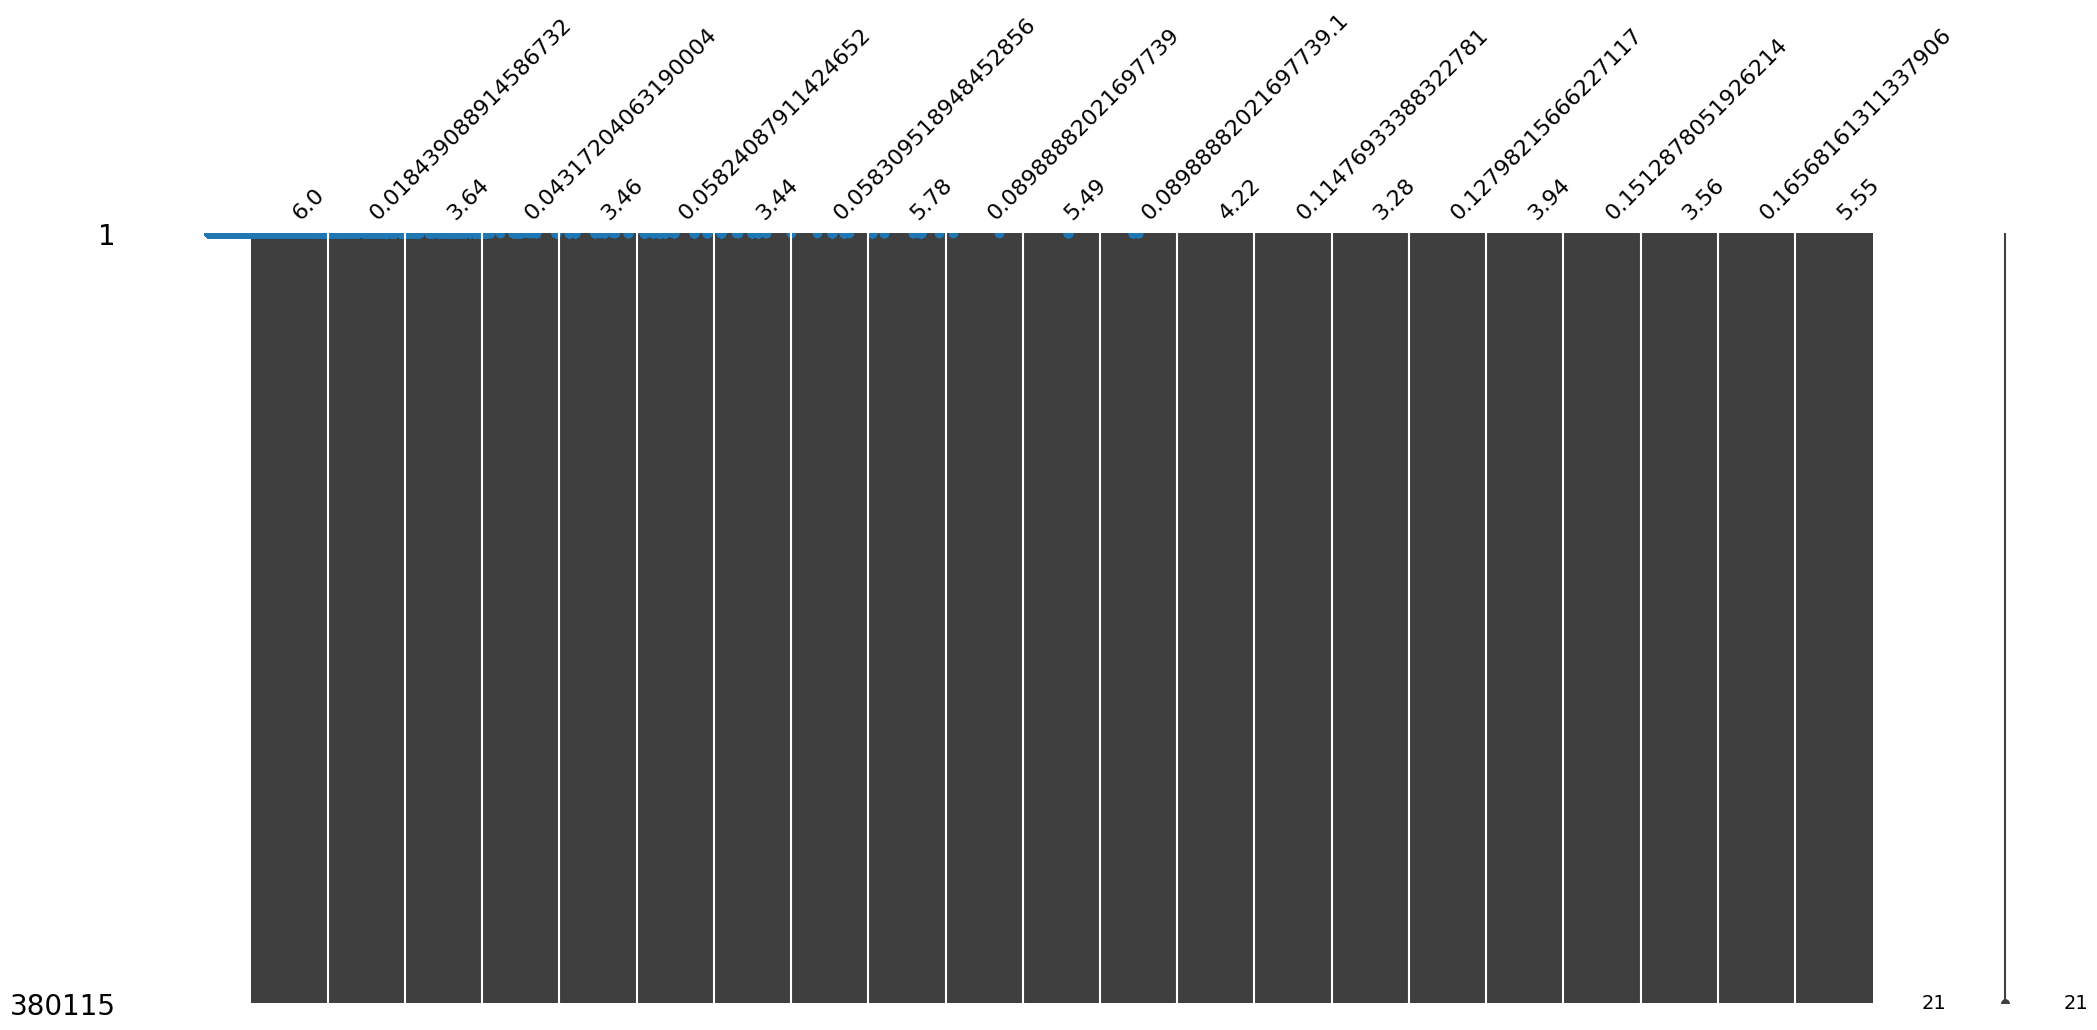

In [18]:

# Reference Random Regression Data Set for testing - generates regression dataset
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import missingno as msno

# Hyper parameter
batch_size = 1

# TODO: 4 features * number of neighbours
# X, y = make_regression(n_samples=10000, n_features=20, noise=0.1, random_state=1)

# Import X, y from csv
dataset_Xy = pd.read_csv('dataset.csv')

# Drop NaN in row for now
dataset_Xy = dataset_Xy.dropna(axis=0)

X = dataset_Xy.iloc[:, :-1].values
y = dataset_Xy.iloc[:, -1].values

# Handle missing data
msno.matrix(dataset_Xy)

# Data Normalization
sc = StandardScaler()
X = sc.fit_transform(X)
y = sc.fit_transform(y.reshape(-1, 1))

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Create data sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X_values, y_values in test_dataloader:
    print(f"Shape of X [Batchsize, Features]: {X_values.shape}")
    print(f"Shape of y: {y_values.shape} {y_values.dtype}")
    break

# Plot train set to see the distribution
print(f"Shape of X: {X_train.shape}")

plt.scatter(X_train[:, 1], y_train[:])
plt.show()

In [20]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    # Do not use mps as this has a bug with float to int conversion: https://discuss.pytorch.org/t/really-low-accuraccy-of-0/152085/4
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Hyper parameter
epochs = 10
learn_rate = 0.0001

## The number of nearest neighbours. More neighbours should smooth out.
nearest_neighbors_count = nearest_neighbors_count

## Input features: Temperature, Pressure, Humidity, Location -> Distance to surrounding sensor
number_of_if = 2
number_of_features = number_of_if * nearest_neighbors_count # 20 atm

# Define model
class TemperatureInterpolationForLocation(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(number_of_features, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


model = TemperatureInterpolationForLocation().to(device)
print(model)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, n_correct, n_wrong = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred_val = pred[0].type(torch.float).item()
            lower_b = y[0].type(torch.float).item() - 0.25
            upper_b = y[0].type(torch.float).item() - 0.25
            if lower_b < pred_val < upper_b:
                n_correct += 1
            else:
                n_wrong += 1
    test_loss /= num_batches
    acc = (n_correct * 1.0) / (n_correct + n_wrong)
    print(
        f"Test Error: \n Accuracy: {(acc*100):>0.1f}%, Avg loss: {test_loss:>8f} \n")


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Using cpu device
TemperatureInterpolationForLocation(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 3.197607  [    1/266080]
loss: 0.153429  [  101/266080]
loss: 0.281433  [  201/266080]
loss: 0.000167  [  301/266080]
loss: 0.869661  [  401/266080]
loss: 0.008718  [  501/266080]
loss: 0.291472  [  601/266080]
loss: 0.250374  [  701/266080]
loss: 1.285336  [  801/266080]
loss: 0.006966  [  901/266080]
loss: 0.000018  [ 1001/266080]
loss: 0.668587  [ 1101/266080]
loss: 1.138703  [ 1201/266080]
loss: 1.355704  [ 1301/266080]
loss: 1.590111  [ 1401/266080]
loss: 0.265118  [ 1501/266080]
loss: 0.459508  [ 1601/266080]
loss: 0.178975  [ 1701/266080]
loss: 0.205140  [ 1801/266080]
loss: 0.584396  [ 1901/266080]
loss: 1.187650  [ 2001/266080]
loss: 0.027166  [ 2101/266080]
loss: 0.000820  [ 2201/2

In [26]:
model.eval()

# Disable weight updates
with torch.no_grad():
    for i in range(10):
        x, y = X_test[i], y_test[i]
        x = x.to(device)
        pred = model(x)
        predicted, actual = pred[0], y
        print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "0.0461483895778656", Actual: "tensor([0.1212])"
Predicted: "-0.8295500874519348", Actual: "tensor([-0.0294])"
Predicted: "-0.06418171525001526", Actual: "tensor([-0.0294])"
Predicted: "-0.1980007290840149", Actual: "tensor([-0.5133])"
Predicted: "-0.33056163787841797", Actual: "tensor([-0.2982])"
Predicted: "0.7225674390792847", Actual: "tensor([0.6427])"
Predicted: "-2.4477462768554688", Actual: "tensor([-2.5565])"
Predicted: "-1.447622537612915", Actual: "tensor([-1.6425])"
Predicted: "0.2322632372379303", Actual: "tensor([0.3470])"
Predicted: "0.23604696989059448", Actual: "tensor([0.2233])"
